|<div style="width:330px"><img src="https://www.ufz.de/static/custom/weblayout/DefaultInternetLayout/img/logos/ufz_transparent_de_blue.png" width="300"/></div>|<div style="width:290px"><img src="https://discourse.opengeosys.org/uploads/default/original/1X/a288c27cc8f73e6830ad98b8729637a260ce3490.png" width="290"/></div>|<div style="width:330px"><img src="https://github.com/nagelt/Teaching_Scripts/raw/9d9e29ecca4b04eaf7397938eacbf116d37ddc93/Images/TUBAF_Logo_blau.png" width="300"/></div>|
|---|---|--:|

*Mehran Ghasabeh  
Chair of Soil Mechanics and Foundation Engineering  
Institute of Geotechnics  
Technische Universität Bergakademie Freiberg.*

https://tu-freiberg.de/en/soilmechanics

## Problem Description
In this example, I ran <code>FM1.prj</code> using the material parameters listed in Table 1, with two different solvers: PardisoLU and PETSc. I used PardisoLU with 12 cores and PETSc with a single core. The analyses completed successfully without any issues. However, when I enabled parallelization with PETSc, the analysis halted at a specific time step and did not proceed further.

<table border="1">
  <caption>Table 1: Constitutive parameters for modelling the induced slip of a fault</caption>
  <thead>
    <tr>
      <th>Material</th>
      <th>Parameter</th>
      <th>Value (FM1)</th>
      <th>Value (FM2)</th>
      <th>Unit</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td rowspan="4">Elastic parameters</td>
      <td>Bulk modulus, <i>K</i></td>
      <td>5.9</td>
      <td>5.9</td>
      <td>GPa</td>
    </tr>
    <tr>
      <td>Shear modulus, <i>G</i></td>
      <td>2.3</td>
      <td>2.3</td>
      <td>GPa</td>
    </tr>
    <tr>
      <td>Bulk density, <i>&rho;</i><sub>R</sub></td>
      <td>2450</td>
      <td>2450</td>
      <td>kg/m<sup>3</sup></td>
    </tr>
    <tr>
      <td>Permeability, <i>k</i></td>
      <td>0</td>
      <td>0</td>
      <td>m<sup>2</sup></td>
    </tr>
    <tr>
      <td rowspan="7">Elastoplastic parameters</td>
      <td>Normal Stiffness, <i>k</i><sub>n</sub></td>
      <td>20</td>
      <td>20</td>
      <td>GPa/m</td>
    </tr>
    <tr>
      <td>Shear stiffness, <i>k</i><sub>s</sub></td>
      <td>20</td>
      <td>20</td>
      <td>GPa/m</td>
    </tr>
    <tr>
      <td>Weak plane cohesion, <i>c</i><sub>wp</sub></td>
      <td>0</td>
      <td>0</td>
      <td>MPa</td>
    </tr>
    <tr>
      <td>Weak plane friction angle, <i>&phi;</i><sub>wp</sub></td>
      <td>22</td>
      <td>22</td>
      <td>&deg;</td>
    </tr>
    <tr>
      <td>Weak plane dilatancy angle, <i>&psi;</i><sub>wp</sub></td>
      <td>0</td>
      <td>10</td>
      <td>&deg;</td>
    </tr>
    <tr>
      <td>Initial creation aperture, <i>b</i><sub>i</sub></td>
      <td>28</td>
      <td>0</td>
      <td>&mu;m</td>
    </tr>
    <tr>
      <td>Initial aperture, <i>b</i><sub>0</sub></td>
      <td>0</td>
      <td>10</td>
      <td>&mu;m</td>
    </tr>
    <tr>
      <td rowspan="3">Hydraulic parameters</td>
      <td>Permeability of intact rock, <i>k</i><sub>M</sub></td>
      <td>10<sup>&minus;22</sup></td>
      <td>10<sup>&minus;22</sup></td>
      <td>m<sup>2</sup></td>
    </tr>
    <tr>
      <td>Initial aperture, <i>b</i><sub>0</sub></td>
      <td>10</td>
      <td>10</td>
      <td>&mu;m</td>
    </tr>
    <tr>
      <td>Biot'</i>s coefficieni<i>>&alpha;</i></td>
      <td>0.95</td>
      <td>0.95</td>
      <td>-</td>
    </tr>
    <tr>
      <td rowspan="2">Fluid</td>
      <td>Density, <i>&rho;</i><sub>f</sub></td>
      <td>1000</td>
      <td>1000</td>
      <td>kg/m<sup>3</sup></td>
    </tr>
    <tr>
      <td></i>Viscosity, <u;</i></td>
      <td>1000</td>
      <td>1000</td>
      <td>Pa&middot;s</td>
    </tr>
  </tbody>
</ta</i>

In [19]:
import math
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyvista as pv
import vtuIO

## To run the simulations through the jupyternotebook, the following lib is imported
from ogs6py.ogs import OGS

In [20]:
# Some plot settings
plt.rcParams["lines.linewidth"] = 3.0
plt.rcParams["lines.color"] = "black"
plt.rcParams["legend.frameon"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["legend.fontsize"] = 16
plt.rcParams["font.size"] = 16
plt.rcParams["axes.spines.right"] = True
plt.rcParams["axes.spines.top"] = True
plt.rcParams["axes.spines.left"] = True
plt.rcParams["axes.spines.bottom"] = True
plt.rcParams["axes.axisbelow"] = True

# FM1 Model

## Injection pressure

In [21]:
dt = np.array(
    [0, 1, 1, 22.3, 1, 76, 1, 56, 1, 55, 1, 53, 1, 49, 1, 102, 1, 32, 1, 47, 100, 200]
)  # seconds
p = np.array(
    [
        0.5,
        0.5,
        0.7446,
        0.7446,
        1.919,
        1.919,
        3.627,
        3.627,
        4.094,
        4.094,
        4.511,
        4.5411,
        4.99,
        4.99,
        5.484,
        5.484,
        6.302,
        6.302,
        3.382,
        3.382,
        3.382,
        3.382,
    ]
)  # MPa

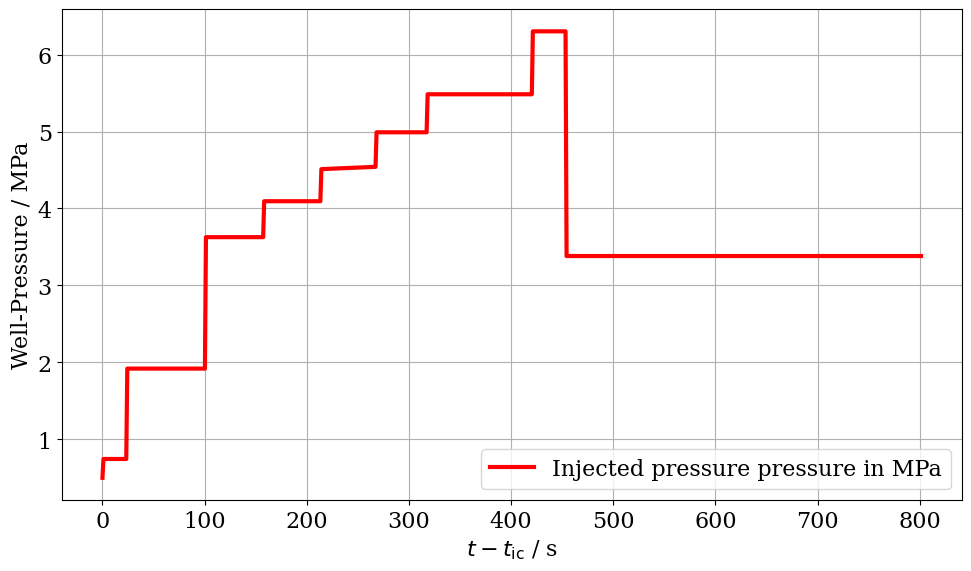

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    dt.cumsum()[1:] - dt[1],
    p[1:],
    label="Injected pressure pressure in MPa",
    color="red",
)
ax.set_xlabel("$t-t_\\mathrm{ic}$ / s")
ax.set_ylabel("Well-Pressure / MPa")
ax.legend()
ax.grid(True)
fig.tight_layout()

## Run analysis using ParsidoLU solver on 12 cores

In [23]:
PATH_OGS_PRADISOLU_1 = "~/build/release/bin"
mpirun_pardisolu_1 = "OMP_NUM_THREADS=12 OGS_ASM_THREADS=12"

In [24]:
import os
from pathlib import Path

model_1 = OGS(INPUT_FILE="FM1.prj", PROJECT_FILE="FM1.prj", ogs_mode="silent")
model_1.write_input()

# Define output directory, including viscosity in the name
out_dir_1 = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out_PardisoLU_12_cores"))
if not out_dir_1.exists():
    out_dir_1.mkdir(parents=True)

# Run simulation
print(f"Running simulation with PardisoLU on 12 cores")
model_1.run_model(
    path=PATH_OGS_PRADISOLU_1,
    logfile=str(out_dir_1 / "out_PardisoLU_12_cores.txt"),
    wrapper=mpirun_pardisolu_1,
    args=f"-o {out_dir_1}",
)

Running simulation with PardisoLU on 12 cores
OGS finished with project file FM1.prj.
Execution took 801.6016240119934 s


## Run analysis using PETSc solver on single core

In [31]:
PATH_OGS_PETSc_1 = "~/build/release-petsc/bin"
mpirun_petsc_1 = ""

In [32]:
model_2 = OGS(INPUT_FILE="FM1.prj", PROJECT_FILE="FM1.prj", ogs_mode="silent")
model_2.write_input()

# Define output directory, including viscosity in the name
out_dir_2 = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out_PETSc_signle_core"))
if not out_dir_2.exists():
    out_dir_2.mkdir(parents=True)

# Run simulation
print(f"Running simulation with PETSc on single core")
model_2.run_model(
    path=PATH_OGS_PETSc_1,
    logfile=str(out_dir_2 / "out_PETSc_singl_core.txt"),
    wrapper=mpirun_petsc_1,
    args=f"-o {out_dir_2}",
)

Running simulation with PETSc on single cores
OGS finished with project file FM1.prj.
Execution took 1386.89355802536 s


## Run analysis using PETSc solver with parallelization on 12 cores

In [35]:
PATH_OGS_PETSc_2 = "~/build/release-petsc/bin"
mpirun_petsc_2 = "mpiexec -n 12"

In [ ]:
model_3 = OGS(INPUT_FILE="FM1.prj", PROJECT_FILE="FM1.prj", ogs_mode="silent")
model_3.write_input()

# Define output directory, including viscosity in the name
out_dir_3 = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out_PETSc_12_cores"))
if not out_dir_3.exists():
    out_dir_3.mkdir(parents=True)

# Run simulation
print(f"Running simulation with PETSc on 12 cores")
model_3.run_model(
    path=PATH_OGS_PETSc_2,
    logfile=str(out_dir_3 / "out_PETSc_12_core.txt"),
    wrapper=mpirun_petsc_2,
    args=f"-o {out_dir_3}",
)

Running simulation with PETSc on 12 cores
